주식 시세 기반으로 수익률을 산출하고 이를 모델별 분석된 데이터와 비교
1. 대상 데이터
 가. 주식 시세
 나. 감정 분석 결과
2. 데이터 병합 방법 : 감정 분석 결과와 주식을 병합하되 감정 분석 결과는 휴일자가 있으므로 아래와 같이 진행
 가. 2017-09-01~2023-08-30까지 df_date DataFrame 생성
    df_date를 생성하는 이유는 주식 시세는 휴일에 데이터가 없고 감정분석 결과 데이터는 평일 데이터가 없을 수도 있기 때문
    (애널리스트 보고서는 430건만 있음/시세는 1738건)
 나. 삼성전자 주식 시세 Load 및 수익률 데이터 생성 및 라벨링(휴일자도 생성)
 다. 감정분석 결과 Load 및 라벨링 및 데이터 병합
 라. 라벨링 결과 비교
4. 라벨링은 아래와 같이 진행
 1) 수익률   : 0초과 : 1/0미만 : -1/ 0 : 0
 2) 감정지수 : 0초과 : 1/0미만 : -1/ 0 : 0
4. 대상
 1) 수익률 : 1일,1주(5일),2주(10일),1개월(21일)
 2) 모델 : KoBERT,KoFinBERT,ChatGPT

1. 2017-09-01~2023-08-30까지 df_date DataFrame 생성

In [1]:
import pandas as pd
import numpy as np
import FinanceDataReader as fdr
from openpyxl import load_workbook
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
# 한글 폰트 설정
rcParams['font.family'] = 'Malgun Gothic'  # 맑은 고딕으로 설정
rcParams['axes.unicode_minus'] = False     # 음수 기호 문제 해결

In [2]:
# 날짜 범위를 생성
date_range = pd.date_range(start='2017-09-01', end='2024-08-30')

# DataFrame 생성
df_date = pd.DataFrame(date_range, columns=['Date'])

In [3]:
df_date

,Date
0,2017-09-01
1,2017-09-02
2,2017-09-03
3,2017-09-04
4,2017-09-05
...,...
2551,2024-08-26
2552,2024-08-27
2553,2024-08-28
2554,2024-08-29


2. 삼성전자 주식 시세 Load 및 수익률 데이터 생성

In [5]:
df_sec_price = fdr.DataReader('KRX:005930', '2017-09-01')

In [6]:
df_sec_price

,Open,High,Low,Close,Volume,Change,UpDown,Comp,Amount,MarCap,Shares
Date,,,,,,,,,,,
2017-09-01,46460,46640,46300,46480,212834,0.0035,1,160,494803743685,301581980056000,129768494
2017-09-04,45780,46360,45500,46040,158870,-0.0095,2,-440,365737156000,298727073188000,129768494
2017-09-05,46240,46900,45960,46760,234322,0.0156,1,720,546005819000,303398738972000,129768494
2017-09-06,46760,47180,46700,47000,216221,0.0051,1,240,507656285446,304955960900000,129768494
2017-09-07,47000,48220,47000,48120,193530,0.0238,1,1120,463090988525,312222996564000,129768494
...,...,...,...,...,...,...,...,...,...,...,...
2024-10-07,60200,61900,59500,61000,35066533,0.0066,1,400,2118597389800,364156735550000,5969782550
2024-10-08,60000,61000,59900,60300,27411786,-0.0115,2,-700,1652788512596,359977887765000,5969782550
2024-10-10,60100,60200,58900,58900,45262214,-0.0232,2,-1400,2687253337620,351620192195000,5969782550


In [7]:
df_sec_price = df_sec_price.reset_index()

In [8]:
df_sec_price = df_sec_price[['Date','Close','Volume']]

In [9]:
df_sec_price.head(21)

,Date,Close,Volume
0,2017-09-01,46480,212834
1,2017-09-04,46040,158870
2,2017-09-05,46760,234322
3,2017-09-06,47000,216221
4,2017-09-07,48120,193530
5,2017-09-08,49080,217860
6,2017-09-11,49800,207495
7,2017-09-12,49600,240595
8,2017-09-13,49620,187140
9,2017-09-14,50300,284095


아래 요건을 참조하여 데이터 세팅
20170901(금) text는 10일 수익률은 20170904-20240915 삼성전자 종가데이터와 비교
20170902(토) text는 10일 수익률은 20170904-20240915 삼성전자 종가데이터와 비교
20170903(일) text는 10일 수익률은 20170904-20240915 삼성전자 종가데이터와 비교
20170904(월) text는 10일 수익률은 20170905-20240918 삼성전자 종가데이터와 비교

In [11]:
df_sec_price['t+1 Close']  = df_sec_price['Close'].shift(-1) 
df_sec_price['t+2 Close']  = df_sec_price['Close'].shift(-2)  # 1일
df_sec_price['t+6 Close']  = df_sec_price['Close'].shift(-5)  # 1주(5일) 
df_sec_price['t+11 Close'] = df_sec_price['Close'].shift(-10) # 2주(10일)
# 20240830일 기준 1개월 Data는 20241008(T+21)일 부터 사용가능한 것을 판단됨
df_sec_price['t+22 Close'] = df_sec_price['Close'].shift(-22) 

In [14]:
df_sec_price.head(21)

,Date,Close,Volume,t+1 Close,t+2 Close,t+6 Close,t+11 Close,t+22 Close
0,2017-09-01,46480,212834,46040.0,46760.0,49080.0,50400.0,54640.0
1,2017-09-04,46040,158870,46760.0,47000.0,49800.0,52480.0,54800.0
2,2017-09-05,46760,234322,47000.0,48120.0,49600.0,52120.0,54000.0
3,2017-09-06,47000,216221,48120.0,49080.0,49620.0,52220.0,53920.0
4,2017-09-07,48120,193530,49080.0,49800.0,50300.0,52800.0,54800.0
5,2017-09-08,49080,217860,49800.0,49600.0,50400.0,53000.0,54760.0
6,2017-09-11,49800,207495,49600.0,49620.0,52480.0,53620.0,52980.0
7,2017-09-12,49600,240595,49620.0,50300.0,52120.0,51660.0,53840.0
8,2017-09-13,49620,187140,50300.0,50400.0,52220.0,51680.0,54300.0
9,2017-09-14,50300,284095,50400.0,52480.0,52800.0,51260.0,54040.0


In [16]:
df_sec_price['1d_profit_rt'] = (df_sec_price['t+2 Close']-df_sec_price['t+1 Close'])/df_sec_price['t+1 Close'] # 1일 수익률
df_sec_price['1w_profit_rt'] = (df_sec_price['t+6 Close']-df_sec_price['t+1 Close'])/df_sec_price['t+1 Close'] # 1주 수익률
df_sec_price['2w_profit_rt'] = (df_sec_price['t+11 Close']-df_sec_price['t+1 Close'])/df_sec_price['t+1 Close'] # 2주 수익률
df_sec_price['1m_profit_rt'] = (df_sec_price['t+22 Close']-df_sec_price['t+1 Close'])/df_sec_price['t+1 Close'] # 1개월 수익률

In [17]:
df_sec_price

,Date,Close,Volume,t+1 Close,t+2 Close,t+6 Close,t+11 Close,t+22 Close,1d_profit_rt,1w_profit_rt,2w_profit_rt,1m_profit_rt
0,2017-09-01,46480,212834,46040.0,46760.0,49080.0,50400.0,54640.0,0.015639,0.066030,0.094700,0.186794
1,2017-09-04,46040,158870,46760.0,47000.0,49800.0,52480.0,54800.0,0.005133,0.065013,0.122327,0.171942
2,2017-09-05,46760,234322,47000.0,48120.0,49600.0,52120.0,54000.0,0.023830,0.055319,0.108936,0.148936
3,2017-09-06,47000,216221,48120.0,49080.0,49620.0,52220.0,53920.0,0.019950,0.031172,0.085204,0.120532
4,2017-09-07,48120,193530,49080.0,49800.0,50300.0,52800.0,54800.0,0.014670,0.024857,0.075795,0.116544
...,...,...,...,...,...,...,...,...,...,...,...,...
1740,2024-10-07,61000,35066533,60300.0,58900.0,NaN,NaN,NaN,-0.023217,NaN,NaN,NaN
1741,2024-10-08,60300,27411786,58900.0,59300.0,NaN,NaN,NaN,0.006791,NaN,NaN,NaN
1742,2024-10-10,58900,45262214,59300.0,60800.0,NaN,NaN,NaN,0.025295,NaN,NaN,NaN
1743,2024-10-11,59300,29623969,60800.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
df_sec_price = df_sec_price[['Date','1d_profit_rt','1w_profit_rt','2w_profit_rt','1m_profit_rt','Close','Volume','t+1 Close','t+2 Close','t+6 Close','t+11 Close','t+22 Close']]

In [19]:
# df_sec_price가 2024-08-30 이전인 경우만 필터링
df_sec_price = df_sec_price[df_sec_price['Date'] <='2024-08-30']

In [20]:
df_sec_price.tail(10) # 2024-08-30 t+21 종가 데이터는 20241007 16시 이후 확정

,Date,1d_profit_rt,1w_profit_rt,2w_profit_rt,1m_profit_rt,Close,Volume,t+1 Close,t+2 Close,t+6 Close,t+11 Close,t+22 Close
1710,2024-08-19,-0.007605,-0.035488,-0.057034,-0.206591,78300,14146565,78900.0,78300.0,76100.0,74400.0,62600.0
1711,2024-08-20,0.000000,-0.031928,-0.074074,-0.192848,78900,10683836,78300.0,78300.0,75800.0,72500.0,63200.0
1712,2024-08-21,-0.007663,-0.024266,-0.106003,-0.205619,78300,7805598,78300.0,77700.0,76400.0,70000.0,62200.0
1713,2024-08-22,-0.020592,-0.047619,-0.111969,-0.167310,78300,8149101,77700.0,76100.0,74000.0,69000.0,64700.0
1714,2024-08-23,-0.003942,-0.023653,-0.094612,-0.156373,77700,9420306,76100.0,75800.0,74300.0,68900.0,64200.0
1715,2024-08-26,0.007916,-0.018470,-0.109499,-0.188654,76100,15655938,75800.0,76400.0,74400.0,67500.0,61500.0
1716,2024-08-27,-0.031414,-0.051047,-0.133508,-0.197644,75800,11130145,76400.0,74000.0,72500.0,66200.0,61300.0
1717,2024-08-28,0.004054,-0.054054,-0.122973,-0.181081,76400,9794514,74000.0,74300.0,70000.0,64900.0,60600.0
1718,2024-08-29,0.001346,-0.071332,-0.107672,-0.179004,74000,16884479,74300.0,74400.0,69000.0,66300.0,61000.0
1719,2024-08-30,-0.025538,-0.073925,-0.134409,-0.189516,74300,16358520,74400.0,72500.0,68900.0,64400.0,60300.0


수익률과 labeling

In [22]:
def label_profit(profit):
    if profit > 0:
        return 1
    elif profit < 0:
        return -1
    else:
        return 0

# df_sec_label 생성 및 컬럼 추가
df_sec_return_label = df_sec_price[['Date','1d_profit_rt','1w_profit_rt','2w_profit_rt','1m_profit_rt']].copy()

# loc을 사용하여 값 할당
df_sec_return_label.loc[:, '1d_label'] = df_sec_price['1d_profit_rt'].apply(label_profit)
df_sec_return_label.loc[:, '1w_label'] = df_sec_price['1w_profit_rt'].apply(label_profit)
df_sec_return_label.loc[:, '2w_label'] = df_sec_price['2w_profit_rt'].apply(label_profit)
df_sec_return_label.loc[:, '1m_label'] = df_sec_price['1m_profit_rt'].apply(label_profit)

In [23]:
df_sec_return_label

,Date,1d_profit_rt,1w_profit_rt,2w_profit_rt,1m_profit_rt,1d_label,1w_label,2w_label,1m_label
0,2017-09-01,0.015639,0.066030,0.094700,0.186794,1,1,1,1
1,2017-09-04,0.005133,0.065013,0.122327,0.171942,1,1,1,1
2,2017-09-05,0.023830,0.055319,0.108936,0.148936,1,1,1,1
3,2017-09-06,0.019950,0.031172,0.085204,0.120532,1,1,1,1
4,2017-09-07,0.014670,0.024857,0.075795,0.116544,1,1,1,1
...,...,...,...,...,...,...,...,...,...
1715,2024-08-26,0.007916,-0.018470,-0.109499,-0.188654,1,-1,-1,-1
1716,2024-08-27,-0.031414,-0.051047,-0.133508,-0.197644,-1,-1,-1,-1
1717,2024-08-28,0.004054,-0.054054,-0.122973,-0.181081,1,-1,-1,-1
1718,2024-08-29,0.001346,-0.071332,-0.107672,-0.179004,1,-1,-1,-1


In [24]:
# 데이터 병합
df_sec_return_label_merge = pd.merge(df_date, df_sec_return_label, on='Date', how='left')

In [25]:
df_sec_return_label_merge # 2017-09-02/2017-09-02 데이터 비워있음

,Date,1d_profit_rt,1w_profit_rt,2w_profit_rt,1m_profit_rt,1d_label,1w_label,2w_label,1m_label
0,2017-09-01,0.015639,0.066030,0.094700,0.186794,1.0,1.0,1.0,1.0
1,2017-09-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-09-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-09-04,0.005133,0.065013,0.122327,0.171942,1.0,1.0,1.0,1.0
4,2017-09-05,0.023830,0.055319,0.108936,0.148936,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...
2551,2024-08-26,0.007916,-0.018470,-0.109499,-0.188654,1.0,-1.0,-1.0,-1.0
2552,2024-08-27,-0.031414,-0.051047,-0.133508,-0.197644,-1.0,-1.0,-1.0,-1.0
2553,2024-08-28,0.004054,-0.054054,-0.122973,-0.181081,1.0,-1.0,-1.0,-1.0
2554,2024-08-29,0.001346,-0.071332,-0.107672,-0.179004,1.0,-1.0,-1.0,-1.0


In [26]:
df_sec_return_label_merge

,Date,1d_profit_rt,1w_profit_rt,2w_profit_rt,1m_profit_rt,1d_label,1w_label,2w_label,1m_label
0,2017-09-01,0.015639,0.066030,0.094700,0.186794,1.0,1.0,1.0,1.0
1,2017-09-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-09-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-09-04,0.005133,0.065013,0.122327,0.171942,1.0,1.0,1.0,1.0
4,2017-09-05,0.023830,0.055319,0.108936,0.148936,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...
2551,2024-08-26,0.007916,-0.018470,-0.109499,-0.188654,1.0,-1.0,-1.0,-1.0
2552,2024-08-27,-0.031414,-0.051047,-0.133508,-0.197644,-1.0,-1.0,-1.0,-1.0
2553,2024-08-28,0.004054,-0.054054,-0.122973,-0.181081,1.0,-1.0,-1.0,-1.0
2554,2024-08-29,0.001346,-0.071332,-0.107672,-0.179004,1.0,-1.0,-1.0,-1.0


In [27]:
# 휴일데이터는 전일자로 채우도록 함
df_sec_return_label_merge['1d_profit_rt'] = df_sec_return_label_merge['1d_profit_rt'].ffill()
df_sec_return_label_merge['1w_profit_rt'] = df_sec_return_label_merge['1w_profit_rt'].ffill()
df_sec_return_label_merge['2w_profit_rt'] = df_sec_return_label_merge['2w_profit_rt'].ffill()
df_sec_return_label_merge['1m_profit_rt'] = df_sec_return_label_merge['1m_profit_rt'].ffill() 

df_sec_return_label_merge['1d_label'] = df_sec_return_label_merge['1d_label'].ffill()
df_sec_return_label_merge['1w_label'] = df_sec_return_label_merge['1w_label'].ffill()
df_sec_return_label_merge['2w_label'] = df_sec_return_label_merge['2w_label'].ffill()
df_sec_return_label_merge['1m_label'] = df_sec_return_label_merge['1m_label'].ffill() 

# 1d_label, 1w_label, 2w_label, 1m_label을 정수형으로 변환
df_sec_return_label_merge['1d_label'] = df_sec_return_label_merge['1d_label'].astype(int)
df_sec_return_label_merge['1w_label'] = df_sec_return_label_merge['1w_label'].astype(int)
df_sec_return_label_merge['2w_label'] = df_sec_return_label_merge['2w_label'].astype(int)
df_sec_return_label_merge['1m_label'] = df_sec_return_label_merge['1m_label'].astype(int)

In [28]:
df_sec_return_label_merge # 2017-09-02/2017-09-02 데이터 채워짐

,Date,1d_profit_rt,1w_profit_rt,2w_profit_rt,1m_profit_rt,1d_label,1w_label,2w_label,1m_label
0,2017-09-01,0.015639,0.066030,0.094700,0.186794,1,1,1,1
1,2017-09-02,0.015639,0.066030,0.094700,0.186794,1,1,1,1
2,2017-09-03,0.015639,0.066030,0.094700,0.186794,1,1,1,1
3,2017-09-04,0.005133,0.065013,0.122327,0.171942,1,1,1,1
4,2017-09-05,0.023830,0.055319,0.108936,0.148936,1,1,1,1
...,...,...,...,...,...,...,...,...,...
2551,2024-08-26,0.007916,-0.018470,-0.109499,-0.188654,1,-1,-1,-1
2552,2024-08-27,-0.031414,-0.051047,-0.133508,-0.197644,-1,-1,-1,-1
2553,2024-08-28,0.004054,-0.054054,-0.122973,-0.181081,1,-1,-1,-1
2554,2024-08-29,0.001346,-0.071332,-0.107672,-0.179004,1,-1,-1,-1


3. 감정분석 결과 Load 및 라벨링 및 데이터 병합

In [182]:
import pandas as pd

# 파일 리스트
file_list = [
'./Text_Data/bigkinds/삼성전자_정치_20170901-20240830_전처리후_원본_daily.csv',
'./Text_Data/bigkinds/삼성전자_경제_20170901-20240830_전처리후_원본_daily_손익.csv',
#'./Text_Data/bigkinds/삼성전자_경제_20170901-20240830_전처리후_원본_daily.csv',   
'./Text_Data/bigkinds/삼성전자_국제_20170901-20240830_전처리후_원본_daily.csv',
'./Text_Data/bigkinds/삼성전자_IT_과학_20170901-20240830_전처리후_원본_daily.csv',
'./Text_Data/bigkinds/삼성전자_사회_20170901-20240830_전처리후_원본_daily.csv',
'./Text_Data/한경_리포트_데이터_기업_SEC_원본_daily.csv',
# 주성
'./Text_Data/Samsung_bigkind_sentiment_merge.csv',
# 웅진
'./Text_Data/Community_Sentiment.csv',
# bigkinds-경제-이익
#'./Text_Data/bigkinds/삼성전자_경제_20170901-20240830_전처리후_원본_profit.csv'
]
# 결과를 저장할 리스트
result_list = []

# 결과를 저장할 DataFrame 초기화
df_accuracy_all = pd.DataFrame()
df_corr_all = pd.DataFrame()

# 작성자마다 컬럼명이 달라 컬럼명 변수 선언
ls_kobert_sentimemt     = ''
ls_kofinbiert_sentiment = ''
ls_chatgpt_sentiment    = ''

# 감정분석 결과 labeling
def label_sentiment(sentiment):
    if profit > 0:
        return 1
    elif profit < 0:
        return -1
    else:
        return 0
 
# 파일별 데이터 건수 확인
for file in file_list:
    df_sentiment_analysis = pd.read_csv(file)  # 엑셀 파일을 읽음
    df_sentiment_analysis = df_sentiment_analysis.rename(columns={'date': 'Date'})

    # 주성
    if file == './Text_Data/Samsung_bigkind_sentiment_merge.csv' :
        ls_kobert_sentimemt     = 'NEWS_kobert_sentiment'
        ls_kofinbiert_sentiment = 'NEWS_kofinbert_sentiment'
        ls_chatgpt_sentiment    = 'NEWS_gpt_sentiment'
    # 웅진
    elif file == './Text_Data/Community_Sentiment.csv' :    
        ls_kobert_sentimemt     = 'Community_KoBert_Sentiment'
        ls_kofinbiert_sentiment = 'Community_KoFinBert_Sentiment'
        ls_chatgpt_sentiment    = 'Community_GPT_Sentiment'
    else :
        ls_kobert_sentimemt     = 'KoBERT_Sentiment'
        ls_kofinbiert_sentiment = 'KoFinBERT_Sentiment'
        ls_chatgpt_sentiment    = 'ChatGPT_Sentiment'
   
    df_sentiment_analysis.loc[:, 'KoBERT_label']    = df_sentiment_analysis[ls_kobert_sentimemt].apply(label_profit)
    df_sentiment_analysis.loc[:, 'KoFinBERT_label'] = df_sentiment_analysis[ls_kofinbiert_sentiment].apply(label_profit)
    df_sentiment_analysis.loc[:, 'ChatGPT_label']   = df_sentiment_analysis[ls_chatgpt_sentiment].apply(label_profit)

    # 특정 Date의 Date컬럼이 date형으로 인식하지 못하즌 것을 감안한 추가
    df_sentiment_analysis['Date'] = pd.to_datetime(df_sentiment_analysis['Date'])
    df_sec_return_label_merge['Date'] = pd.to_datetime(df_sec_return_label_merge['Date'])

    # 감정 분석 데이터와 수익률 데이터의 병합
    df_sentiment_analysis_merge = pd.merge(df_sentiment_analysis, df_sec_return_label_merge, on='Date', how='inner')

    # KoBERT_label과 1d_label이 일치하면 True, 아니면 False로 설정
    df_sentiment_analysis_merge['1d_KoBERT_match']    = df_sentiment_analysis_merge['KoBERT_label']    == df_sentiment_analysis_merge['1d_label']
    df_sentiment_analysis_merge['1d_KoFinBERT_match'] = df_sentiment_analysis_merge['KoFinBERT_label'] == df_sentiment_analysis_merge['1d_label']
    df_sentiment_analysis_merge['1d_ChatGPT_match']   = df_sentiment_analysis_merge['ChatGPT_label']   == df_sentiment_analysis_merge['1d_label']
    df_sentiment_analysis_merge['1w_KoBERT_match']    = df_sentiment_analysis_merge['KoBERT_label']    == df_sentiment_analysis_merge['1w_label']
    df_sentiment_analysis_merge['1w_KoFinBERT_match'] = df_sentiment_analysis_merge['KoFinBERT_label'] == df_sentiment_analysis_merge['1w_label']
    df_sentiment_analysis_merge['1w_ChatGPT_match']   = df_sentiment_analysis_merge['ChatGPT_label']   == df_sentiment_analysis_merge['1w_label']
    df_sentiment_analysis_merge['2w_KoBERT_match']    = df_sentiment_analysis_merge['KoBERT_label']    == df_sentiment_analysis_merge['2w_label']
    df_sentiment_analysis_merge['2w_KoFinBERT_match'] = df_sentiment_analysis_merge['KoFinBERT_label'] == df_sentiment_analysis_merge['2w_label']
    df_sentiment_analysis_merge['2w_ChatGPT_match']   = df_sentiment_analysis_merge['ChatGPT_label']   == df_sentiment_analysis_merge['2w_label']
    df_sentiment_analysis_merge['1m_KoBERT_match']    = df_sentiment_analysis_merge['KoBERT_label']    == df_sentiment_analysis_merge['1m_label']
    df_sentiment_analysis_merge['1m_KoFinBERT_match'] = df_sentiment_analysis_merge['KoFinBERT_label'] == df_sentiment_analysis_merge['1m_label']
    df_sentiment_analysis_merge['1m_ChatGPT_match']   = df_sentiment_analysis_merge['ChatGPT_label']   == df_sentiment_analysis_merge['1m_label']
    # 정확도 측정
    ld_1d_KoBERT_acc      = round(df_sentiment_analysis_merge['1d_KoBERT_match'].sum()/len(df_sentiment_analysis_merge)*100,2)
    ld_1d_KoFinBERT_acc   = round(df_sentiment_analysis_merge['1d_KoFinBERT_match'].sum()/len(df_sentiment_analysis_merge)*100,2)
    ld_1d_ChatGPT_acc     = round(df_sentiment_analysis_merge['1d_ChatGPT_match'].sum()/len(df_sentiment_analysis_merge)*100,2)
    ld_1w_KoBERT_acc      = round(df_sentiment_analysis_merge['1w_KoBERT_match'].sum()/len(df_sentiment_analysis_merge)*100,2)
    ld_1w_KoFinBERT_acc   = round(df_sentiment_analysis_merge['1w_KoFinBERT_match'].sum()/len(df_sentiment_analysis_merge)*100,2)
    ld_1w_ChatGPT_acc     = round(df_sentiment_analysis_merge['1w_ChatGPT_match'].sum()/len(df_sentiment_analysis_merge)*100,2)
    ld_2w_KoBERT_acc      = round(df_sentiment_analysis_merge['2w_KoBERT_match'].sum()/len(df_sentiment_analysis_merge)*100,2)
    ld_2w_KoFinBERT_acc   = round(df_sentiment_analysis_merge['2w_KoFinBERT_match'].sum()/len(df_sentiment_analysis_merge)*100,2)
    ld_2w_ChatGPT_acc     = round(df_sentiment_analysis_merge['2w_ChatGPT_match'].sum()/len(df_sentiment_analysis_merge)*100,2)
    ld_1m_KoBERT_acc      = round(df_sentiment_analysis_merge['1m_KoBERT_match'].sum()/len(df_sentiment_analysis_merge)*100,2)
    ld_1m_KoFinBERT_acc   = round(df_sentiment_analysis_merge['1m_KoFinBERT_match'].sum()/len(df_sentiment_analysis_merge)*100,2)
    ld_1m_ChatGPT_acc     = round(df_sentiment_analysis_merge['1m_ChatGPT_match'].sum()/len(df_sentiment_analysis_merge)*100,2)
    # df_accuracy DataFrame 생성 및 값 추가
    df_accuracy = pd.DataFrame({
        '1d_KoBERT_acc'    : [ld_1d_KoBERT_acc   ],
        '1d_KoFinBERT_acc' : [ld_1d_KoFinBERT_acc],
        '1d_ChatGPT_acc'   : [ld_1d_ChatGPT_acc  ],
        '1w_KoBERT_acc'    : [ld_1w_KoBERT_acc   ],
        '1w_KoFinBERT_acc' : [ld_1w_KoFinBERT_acc],
        '1w_ChatGPT_acc'   : [ld_1w_ChatGPT_acc  ],
        '2w_KoBERT_acc'    : [ld_2w_KoBERT_acc   ],
        '2w_KoFinBERT_acc' : [ld_2w_KoFinBERT_acc],
        '2w_ChatGPT_acc'   : [ld_2w_ChatGPT_acc  ],
        '1m_KoBERT_acc'    : [ld_1m_KoBERT_acc   ],
        '1m_KoFinBERT_acc' : [ld_1m_KoFinBERT_acc],
        '1m_ChatGPT_acc'   : [ld_1m_ChatGPT_acc  ]
    })

    # 상관관계 측정
    ld_1d_KoBERT_corr    = df_sentiment_analysis_merge[ls_kobert_sentimemt].corr(df_sentiment_analysis_merge['1d_profit_rt'])
    ld_1d_KoFinBERT_corr = df_sentiment_analysis_merge[ls_kofinbiert_sentiment].corr(df_sentiment_analysis_merge['1d_profit_rt'])
    ld_1d_ChatGPT_corr   = df_sentiment_analysis_merge[ls_chatgpt_sentiment].corr(df_sentiment_analysis_merge['1d_profit_rt'])
    ld_1w_KoBERT_corr    = df_sentiment_analysis_merge[ls_kobert_sentimemt].corr(df_sentiment_analysis_merge['1w_profit_rt'])
    ld_1w_KoFinBERT_corr = df_sentiment_analysis_merge[ls_kofinbiert_sentiment].corr(df_sentiment_analysis_merge['1w_profit_rt'])
    ld_1w_ChatGPT_corr   = df_sentiment_analysis_merge[ls_chatgpt_sentiment].corr(df_sentiment_analysis_merge['1w_profit_rt'])
    ld_2w_KoBERT_corr    = df_sentiment_analysis_merge[ls_kobert_sentimemt].corr(df_sentiment_analysis_merge['2w_profit_rt'])
    ld_2w_KoFinBERT_corr = df_sentiment_analysis_merge[ls_kofinbiert_sentiment].corr(df_sentiment_analysis_merge['2w_profit_rt'])
    ld_2w_ChatGPT_corr   = df_sentiment_analysis_merge[ls_chatgpt_sentiment].corr(df_sentiment_analysis_merge['2w_profit_rt'])
    ld_1m_KoBERT_corr    = df_sentiment_analysis_merge[ls_kobert_sentimemt].corr(df_sentiment_analysis_merge['1m_profit_rt'])
    ld_1m_KoFinBERT_corr = df_sentiment_analysis_merge[ls_kofinbiert_sentiment].corr(df_sentiment_analysis_merge['1m_profit_rt'])
    ld_1m_ChatGPT_corr   = df_sentiment_analysis_merge[ls_chatgpt_sentiment].corr(df_sentiment_analysis_merge['1m_profit_rt'])
    
    # 상관관계 데이터생성
    df_corr = pd.DataFrame({
        '1d_KoBERT_corr'    : [ld_1d_KoBERT_corr   ],
        '1d_KoFinBERT_corr' : [ld_1d_KoFinBERT_corr],
        '1d_ChatGPT_corr'   : [ld_1d_ChatGPT_corr  ],
        '1w_KoBERT_corr'    : [ld_1w_KoBERT_corr   ],
        '1w_KoFinBERT_corr' : [ld_1w_KoFinBERT_corr],
        '1w_ChatGPT_corr'   : [ld_1w_ChatGPT_corr  ],
        '2w_KoBERT_corr'    : [ld_2w_KoBERT_corr   ],
        '2w_KoFinBERT_corr' : [ld_2w_KoFinBERT_corr],
        '2w_ChatGPT_corr'   : [ld_2w_ChatGPT_corr  ],
        '1m_KoBERT_corr'    : [ld_1m_KoBERT_corr   ],
        '1m_KoFinBERT_corr' : [ld_1m_KoFinBERT_corr],
        '1m_ChatGPT_corr'   : [ld_1m_ChatGPT_corr  ]
    })

    # df_accuracy와 df_corr을 각각 누적 저장
    df_accuracy_all = pd.concat([df_accuracy_all, df_accuracy], ignore_index=True)
    df_corr_all = pd.concat([df_corr_all, df_corr], ignore_index=True)

In [184]:
df_sentiment_analysis_merge

,Date,Community_KoBert_Sentiment,Community_KoFinBert_Sentiment,Community_GPT_Sentiment,KoBERT_label,KoFinBERT_label,ChatGPT_label,1d_profit_rt,1w_profit_rt,2w_profit_rt,...,1d_ChatGPT_match,1w_KoBERT_match,1w_KoFinBERT_match,1w_ChatGPT_match,2w_KoBERT_match,2w_KoFinBERT_match,2w_ChatGPT_match,1m_KoBERT_match,1m_KoFinBERT_match,1m_ChatGPT_match
0,2017-09-01,0.1,-0.2,0.4,1,-1,1,0.015639,0.066030,0.094700,...,True,True,False,True,True,False,True,True,False,True
1,2017-09-02,0.0,0.2,0.5,0,1,1,0.015639,0.066030,0.094700,...,True,False,True,True,False,True,True,False,True,True
2,2017-09-03,0.1,-0.3,-0.2,1,-1,-1,0.015639,0.066030,0.094700,...,False,True,False,False,True,False,False,True,False,False
3,2017-09-06,-0.0,-0.4,-0.5,0,-1,-1,0.019950,0.031172,0.085204,...,False,False,False,False,False,False,False,False,False,False
4,2017-09-07,0.0,-0.0,0.0,0,0,0,0.014670,0.024857,0.075795,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2494,2024-08-26,0.1,-0.4,-0.2,1,-1,-1,0.007916,-0.018470,-0.109499,...,False,False,True,True,False,True,True,False,True,True
2495,2024-08-27,0.1,-0.1,-0.3,1,-1,-1,-0.031414,-0.051047,-0.133508,...,True,False,True,True,False,True,True,False,True,True
2496,2024-08-28,0.0,-0.3,-0.3,0,-1,-1,0.004054,-0.054054,-0.122973,...,False,False,True,True,False,True,True,False,True,True
2497,2024-08-29,0.1,-0.3,-0.3,1,-1,-1,0.001346,-0.071332,-0.107672,...,False,False,True,True,False,True,True,False,True,True


In [186]:
df_sentiment_analysis_merge['1m_label']

0       1
1       1
2       1
3       1
4       1
       ..
2494   -1
2495   -1
2496   -1
2497   -1
2498   -1
Name: 1m_label, Length: 2499, dtype: int32

In [188]:
df_accuracy_all

,1d_KoBERT_acc,1d_KoFinBERT_acc,1d_ChatGPT_acc,1w_KoBERT_acc,1w_KoFinBERT_acc,1w_ChatGPT_acc,2w_KoBERT_acc,2w_KoFinBERT_acc,2w_ChatGPT_acc,1m_KoBERT_acc,1m_KoFinBERT_acc,1m_ChatGPT_acc
0,48.88,12.28,33.03,47.61,9.01,31.46,49.12,9.01,32.18,49.12,8.89,32.18
1,47.04,4.83,4.83,47.16,2.31,2.31,48.25,1.14,1.14,49.08,0.47,0.47
2,47.66,19.51,34.56,49.68,20.45,35.35,48.88,18.29,33.05,48.81,18.07,34.77
3,48.59,35.28,47.99,48.59,35.40,48.03,49.90,36.27,49.26,50.42,36.03,49.94
4,47.85,19.44,34.65,47.61,21.02,35.74,48.46,18.84,33.37,50.76,18.29,35.37
5,29.53,52.79,46.98,29.77,51.40,45.12,27.21,54.65,46.98,29.77,53.49,43.26
6,38.02,29.31,39.23,40.33,29.70,38.61,39.70,28.76,38.61,38.53,30.13,40.91
7,39.10,36.37,38.26,38.14,37.13,39.14,38.34,36.45,39.66,38.90,37.98,40.50


In [92]:
df_corr_all

,1d_KoBERT_corr,1d_KoFinBERT_corr,1d_ChatGPT_corr,1w_KoBERT_corr,1w_KoFinBERT_corr,1w_ChatGPT_corr,2w_KoBERT_corr,2w_KoFinBERT_corr,2w_ChatGPT_corr,1m_KoBERT_corr,1m_KoFinBERT_corr,1m_ChatGPT_corr
0,0.018054,0.012213,-0.009953,-0.011571,-0.014392,-0.029605,0.005763,-0.002613,0.009880,0.007562,-0.008492,-0.037283
1,NaN,NaN,0.000593,NaN,NaN,0.008979,NaN,NaN,-0.011127,NaN,NaN,-0.032615
2,0.020135,0.022904,0.017606,0.031296,-0.023271,-0.012987,0.064627,-0.010654,-0.025157,0.062680,0.015080,0.001289
3,0.010834,-0.004384,-0.045666,0.020908,-0.009266,0.001551,0.013295,-0.012106,-0.005630,0.014583,-0.001159,-0.007049
4,-0.030888,0.019707,0.001443,-0.035761,-0.009533,-0.008402,-0.053721,-0.004288,-0.014035,-0.031667,0.016484,-0.011575
5,-0.024177,-0.011786,0.044463,-0.061115,-0.036364,0.058455,-0.061696,-0.062097,-0.028784,-0.012494,-0.050863,-0.102137
6,-0.007863,-0.037880,-0.014515,-0.011917,-0.041859,0.000005,0.000120,-0.016280,-0.015868,-0.023364,-0.005909,-0.017394
7,-0.002265,-0.022141,-0.025709,-0.001235,-0.018800,-0.026945,-0.001944,-0.021025,-0.026560,-0.000036,-0.029498,-0.019129


EXCEL에 데이터 꽂아넣기

In [132]:
# EXCEL 파일 경로 설정 (기존 파일에 쓰기)
file_path = './Doc/삼성전자 감정점수_수익률 평가.xlsx'

# EXCEL 파일 읽기
wb = load_workbook(file_path)
# 특정 시트 선택 
ws = wb['정확도(T+1)']

# 여러 컬럼 값을 동시에 세팅
for idx, (value1, value2, value3, value4, value5, value6,
          value7, value8, value9, value10, value11, value12 ) in  enumerate(
            zip(df_accuracy_all['1d_KoBERT_acc'], 
                df_accuracy_all['1d_KoFinBERT_acc'], 
                df_accuracy_all['1d_ChatGPT_acc'], 
                df_accuracy_all['1w_KoBERT_acc'], 
                df_accuracy_all['1w_KoFinBERT_acc'], 
                df_accuracy_all['1w_ChatGPT_acc'], 
                df_accuracy_all['2w_KoBERT_acc'], 
                df_accuracy_all['2w_KoFinBERT_acc'], 
                df_accuracy_all['2w_ChatGPT_acc'], 
                df_accuracy_all['1m_KoBERT_acc'], 
                df_accuracy_all['1m_KoFinBERT_acc'], 
                df_accuracy_all['1m_ChatGPT_acc'],
                ), start=3):
    ws[f'B{idx}'] = value1
    ws[f'C{idx}'] = value2
    ws[f'D{idx}'] = value3
    ws[f'E{idx}'] = value4
    ws[f'F{idx}'] = value5
    ws[f'G{idx}'] = value6
    ws[f'H{idx}'] = value7
    ws[f'I{idx}'] = value8
    ws[f'J{idx}'] = value9
    ws[f'K{idx}'] = value10
    ws[f'L{idx}'] = value11
    ws[f'M{idx}'] = value12

# 기존 파일에 저장
wb.save(file_path)

print(f"데이터가 성공적으로 {file_path}에 저장되었습니다.")

PermissionError: [Errno 13] Permission denied: './Doc/삼성전자 감정점수_수익률 평가.xlsx'

In [70]:
# EXCEL 파일 경로 설정 (기존 파일에 쓰기)
file_path = './Doc/삼성전자 감정점수_수익률 평가.xlsx'

# EXCEL 파일 읽기
wb = load_workbook(file_path)
# 특정 시트 선택 
ws = wb['상관계수(T+1)']

# 여러 컬럼 값을 동시에 세팅
for idx, (value1, value2, value3, value4, value5, value6,
          value7, value8, value9, value10, value11, value12 ) in  enumerate(
            zip(df_corr_all['1d_KoBERT_corr'], 
                df_corr_all['1d_KoFinBERT_corr'], 
                df_corr_all['1d_ChatGPT_corr'], 
                df_corr_all['1w_KoBERT_corr'], 
                df_corr_all['1w_KoFinBERT_corr'], 
                df_corr_all['1w_ChatGPT_corr'], 
                df_corr_all['2w_KoBERT_corr'], 
                df_corr_all['2w_KoFinBERT_corr'], 
                df_corr_all['2w_ChatGPT_corr'], 
                df_corr_all['1m_KoBERT_corr'], 
                df_corr_all['1m_KoFinBERT_corr'], 
                df_corr_all['1m_ChatGPT_corr'],
                ), start=3):
    ws[f'B{idx}'] = value1
    ws[f'C{idx}'] = value2
    ws[f'D{idx}'] = value3
    ws[f'E{idx}'] = value4
    ws[f'F{idx}'] = value5
    ws[f'G{idx}'] = value6
    ws[f'H{idx}'] = value7
    ws[f'I{idx}'] = value8
    ws[f'J{idx}'] = value9
    ws[f'K{idx}'] = value10
    ws[f'L{idx}'] = value11
    ws[f'M{idx}'] = value12

# 기존 파일에 저장
wb.save(file_path)

print(f"데이터가 성공적으로 {file_path}에 저장되었습니다.")

데이터가 성공적으로 ./Doc/삼성전자 감정점수_수익률 평가.xlsx에 저장되었습니다.


---------------------------------------------------------------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------------------

아래는 하나씩 분석하는 과정으로 위에 loop에 병합

In [75]:
df_date

,Date
0,2017-09-01
1,2017-09-02
2,2017-09-03
3,2017-09-04
4,2017-09-05
...,...
2551,2024-08-26
2552,2024-08-27
2553,2024-08-28
2554,2024-08-29


In [77]:
df_sentiment_analysis

,Date,Community_KoBert_Sentiment,Community_KoFinBert_Sentiment,Community_GPT_Sentiment,KoBERT_label,KoFinBERT_label,ChatGPT_label
0,2017-09-01,0.1,-0.2,0.4,1,-1,1
1,2017-09-02,0.0,0.2,0.5,0,1,1
2,2017-09-03,0.1,-0.3,-0.2,1,-1,-1
3,2017-09-06,-0.0,-0.4,-0.5,0,-1,-1
4,2017-09-07,0.0,-0.0,0.0,0,0,0
...,...,...,...,...,...,...,...
2494,2024-08-26,0.1,-0.4,-0.2,1,-1,-1
2495,2024-08-27,0.1,-0.1,-0.3,1,-1,-1
2496,2024-08-28,0.0,-0.3,-0.3,0,-1,-1
2497,2024-08-29,0.1,-0.3,-0.3,1,-1,-1


In [79]:
df_sentiment_analysis_merge

,Date,Community_KoBert_Sentiment,Community_KoFinBert_Sentiment,Community_GPT_Sentiment,KoBERT_label,KoFinBERT_label,ChatGPT_label,1d_profit_rt,1w_profit_rt,2w_profit_rt,...,1d_ChatGPT_match,1w_KoBERT_match,1w_KoFinBERT_match,1w_ChatGPT_match,2w_KoBERT_match,2w_KoFinBERT_match,2w_ChatGPT_match,1m_KoBERT_match,1m_KoFinBERT_match,1m_ChatGPT_match
0,2017-09-01,0.1,-0.2,0.4,1,-1,1,0.015639,0.066030,0.094700,...,True,True,False,True,True,False,True,True,False,True
1,2017-09-02,0.0,0.2,0.5,0,1,1,0.015639,0.066030,0.094700,...,True,False,True,True,False,True,True,False,True,True
2,2017-09-03,0.1,-0.3,-0.2,1,-1,-1,0.015639,0.066030,0.094700,...,False,True,False,False,True,False,False,True,False,False
3,2017-09-06,-0.0,-0.4,-0.5,0,-1,-1,0.019950,0.031172,0.085204,...,False,False,False,False,False,False,False,False,False,False
4,2017-09-07,0.0,-0.0,0.0,0,0,0,0.014670,0.024857,0.075795,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2494,2024-08-26,0.1,-0.4,-0.2,1,-1,-1,0.007916,-0.018470,-0.109499,...,False,False,True,True,False,True,True,False,True,True
2495,2024-08-27,0.1,-0.1,-0.3,1,-1,-1,-0.031414,-0.051047,-0.133508,...,True,False,True,True,False,True,True,False,True,True
2496,2024-08-28,0.0,-0.3,-0.3,0,-1,-1,0.004054,-0.054054,-0.122973,...,False,False,True,True,False,True,True,False,True,True
2497,2024-08-29,0.1,-0.3,-0.3,1,-1,-1,0.001346,-0.071332,-0.107672,...,False,False,True,True,False,True,True,False,True,True


In [81]:
# KoBERT_label과 1d_label이 일치하면 True, 아니면 False로 설정
df_sentiment_analysis_merge['1d_KoBERT_match']    = df_sentiment_analysis_merge['KoBERT_label']    == df_sentiment_analysis_merge['1d_label']
df_sentiment_analysis_merge['1d_KoFinBERT_match'] = df_sentiment_analysis_merge['KoFinBERT_label'] == df_sentiment_analysis_merge['1d_label']
df_sentiment_analysis_merge['1d_ChatGPT_match']   = df_sentiment_analysis_merge['ChatGPT_label']   == df_sentiment_analysis_merge['1d_label']
df_sentiment_analysis_merge['1w_KoBERT_match']    = df_sentiment_analysis_merge['KoBERT_label']    == df_sentiment_analysis_merge['1w_label']
df_sentiment_analysis_merge['1w_KoFinBERT_match'] = df_sentiment_analysis_merge['KoFinBERT_label'] == df_sentiment_analysis_merge['1w_label']
df_sentiment_analysis_merge['1w_ChatGPT_match']   = df_sentiment_analysis_merge['ChatGPT_label']   == df_sentiment_analysis_merge['1w_label']
df_sentiment_analysis_merge['2w_KoBERT_match']    = df_sentiment_analysis_merge['KoBERT_label']    == df_sentiment_analysis_merge['2w_label']
df_sentiment_analysis_merge['2w_KoFinBERT_match'] = df_sentiment_analysis_merge['KoFinBERT_label'] == df_sentiment_analysis_merge['2w_label']
df_sentiment_analysis_merge['2w_ChatGPT_match']   = df_sentiment_analysis_merge['ChatGPT_label']   == df_sentiment_analysis_merge['2w_label']
df_sentiment_analysis_merge['1m_KoBERT_match']    = df_sentiment_analysis_merge['KoBERT_label']    == df_sentiment_analysis_merge['1m_label']
df_sentiment_analysis_merge['1m_KoFinBERT_match'] = df_sentiment_analysis_merge['KoFinBERT_label'] == df_sentiment_analysis_merge['1m_label']
df_sentiment_analysis_merge['1m_ChatGPT_match']   = df_sentiment_analysis_merge['ChatGPT_label']   == df_sentiment_analysis_merge['1m_label']

In [83]:
df_sentiment_analysis_merge

,Date,Community_KoBert_Sentiment,Community_KoFinBert_Sentiment,Community_GPT_Sentiment,KoBERT_label,KoFinBERT_label,ChatGPT_label,1d_profit_rt,1w_profit_rt,2w_profit_rt,...,1d_ChatGPT_match,1w_KoBERT_match,1w_KoFinBERT_match,1w_ChatGPT_match,2w_KoBERT_match,2w_KoFinBERT_match,2w_ChatGPT_match,1m_KoBERT_match,1m_KoFinBERT_match,1m_ChatGPT_match
0,2017-09-01,0.1,-0.2,0.4,1,-1,1,0.015639,0.066030,0.094700,...,True,True,False,True,True,False,True,True,False,True
1,2017-09-02,0.0,0.2,0.5,0,1,1,0.015639,0.066030,0.094700,...,True,False,True,True,False,True,True,False,True,True
2,2017-09-03,0.1,-0.3,-0.2,1,-1,-1,0.015639,0.066030,0.094700,...,False,True,False,False,True,False,False,True,False,False
3,2017-09-06,-0.0,-0.4,-0.5,0,-1,-1,0.019950,0.031172,0.085204,...,False,False,False,False,False,False,False,False,False,False
4,2017-09-07,0.0,-0.0,0.0,0,0,0,0.014670,0.024857,0.075795,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2494,2024-08-26,0.1,-0.4,-0.2,1,-1,-1,0.007916,-0.018470,-0.109499,...,False,False,True,True,False,True,True,False,True,True
2495,2024-08-27,0.1,-0.1,-0.3,1,-1,-1,-0.031414,-0.051047,-0.133508,...,True,False,True,True,False,True,True,False,True,True
2496,2024-08-28,0.0,-0.3,-0.3,0,-1,-1,0.004054,-0.054054,-0.122973,...,False,False,True,True,False,True,True,False,True,True
2497,2024-08-29,0.1,-0.3,-0.3,1,-1,-1,0.001346,-0.071332,-0.107672,...,False,False,True,True,False,True,True,False,True,True


In [85]:
df_sentiment_analysis_merge['1d_KoBERT_match']

0        True
1       False
2        True
3       False
4       False
        ...  
2494     True
2495    False
2496    False
2497     True
2498    False
Name: 1d_KoBERT_match, Length: 2499, dtype: bool

In [87]:
ld_1d_KoBERT_acc      = round(df_sentiment_analysis_merge['1d_KoBERT_match'].sum()/len(df_sentiment_analysis_merge)*100,2)
ld_1d_KoFinBERT_acc   = round(df_sentiment_analysis_merge['1d_KoFinBERT_match'].sum()/len(df_sentiment_analysis_merge)*100,2)
ld_1d_ChatGPT_acc     = round(df_sentiment_analysis_merge['1d_ChatGPT_match'].sum()/len(df_sentiment_analysis_merge)*100,2)
ld_1w_KoBERT_acc      = round(df_sentiment_analysis_merge['1w_KoBERT_match'].sum()/len(df_sentiment_analysis_merge)*100,2)
ld_1w_KoFinBERT_acc   = round(df_sentiment_analysis_merge['1w_KoFinBERT_match'].sum()/len(df_sentiment_analysis_merge)*100,2)
ld_1w_ChatGPT_acc     = round(df_sentiment_analysis_merge['1w_ChatGPT_match'].sum()/len(df_sentiment_analysis_merge)*100,2)
ld_2w_KoBERT_acc      = round(df_sentiment_analysis_merge['2w_KoBERT_match'].sum()/len(df_sentiment_analysis_merge)*100,2)
ld_2w_KoFinBERT_acc   = round(df_sentiment_analysis_merge['2w_KoFinBERT_match'].sum()/len(df_sentiment_analysis_merge)*100,2)
ld_2w_ChatGPT_acc     = round(df_sentiment_analysis_merge['2w_ChatGPT_match'].sum()/len(df_sentiment_analysis_merge)*100,2)
ld_1m_KoBERT_acc      = round(df_sentiment_analysis_merge['1m_KoBERT_match'].sum()/len(df_sentiment_analysis_merge)*100,2)
ld_1m_KoFinBERT_acc   = round(df_sentiment_analysis_merge['1m_KoFinBERT_match'].sum()/len(df_sentiment_analysis_merge)*100,2)
ld_1m_ChatGPT_acc     = round(df_sentiment_analysis_merge['1m_ChatGPT_match'].sum()/len(df_sentiment_analysis_merge)*100,2)

In [89]:
ld_1m_ChatGPT_acc

40.5

In [91]:
# df_accuracy DataFrame 생성 및 값 추가
df_accuracy = pd.DataFrame({
    '1d_KoBERT_acc'    : [ld_1d_KoBERT_acc   ],
    '1d_KoFinBERT_acc' : [ld_1d_KoFinBERT_acc],
    '1d_ChatGPT_acc'   : [ld_1d_ChatGPT_acc  ],
    '1w_KoBERT_acc'    : [ld_1w_KoBERT_acc   ],
    '1w_KoFinBERT_acc' : [ld_1w_KoFinBERT_acc],
    '1w_ChatGPT_acc'   : [ld_1w_ChatGPT_acc  ],
    '2w_KoBERT_acc'    : [ld_2w_KoBERT_acc   ],
    '2w_KoFinBERT_acc' : [ld_2w_KoFinBERT_acc],
    '2w_ChatGPT_acc'   : [ld_2w_ChatGPT_acc  ],
    '1m_KoBERT_acc'    : [ld_1m_KoBERT_acc   ],
    '1m_KoFinBERT_acc' : [ld_1m_KoFinBERT_acc],
    '1m_ChatGPT_acc'   : [ld_1m_ChatGPT_acc  ]
})

In [93]:
df_accuracy

,1d_KoBERT_acc,1d_KoFinBERT_acc,1d_ChatGPT_acc,1w_KoBERT_acc,1w_KoFinBERT_acc,1w_ChatGPT_acc,2w_KoBERT_acc,2w_KoFinBERT_acc,2w_ChatGPT_acc,1m_KoBERT_acc,1m_KoFinBERT_acc,1m_ChatGPT_acc
0,39.1,36.37,38.26,38.14,37.13,39.14,38.34,36.45,39.66,38.9,37.98,40.5


In [95]:
ld_1d_KoBERT_corr    = df_sentiment_analysis_merge[ls_kobert_sentimemt].corr(df_sentiment_analysis_merge['1d_profit_rt'])
ld_1d_KoFinBERT_corr = df_sentiment_analysis_merge[ls_kofinbiert_sentiment].corr(df_sentiment_analysis_merge['1d_profit_rt'])
ld_1d_ChatGPT_corr   = df_sentiment_analysis_merge[ls_chatgpt_sentiment].corr(df_sentiment_analysis_merge['1d_profit_rt'])
ld_1w_KoBERT_corr    = df_sentiment_analysis_merge[ls_kobert_sentimemt].corr(df_sentiment_analysis_merge['1w_profit_rt'])
ld_1w_KoFinBERT_corr = df_sentiment_analysis_merge[ls_kofinbiert_sentiment].corr(df_sentiment_analysis_merge['1w_profit_rt'])
ld_1w_ChatGPT_corr   = df_sentiment_analysis_merge[ls_chatgpt_sentiment].corr(df_sentiment_analysis_merge['1w_profit_rt'])
ld_2w_KoBERT_corr    = df_sentiment_analysis_merge[ls_kobert_sentimemt].corr(df_sentiment_analysis_merge['2w_profit_rt'])
ld_2w_KoFinBERT_corr = df_sentiment_analysis_merge[ls_kofinbiert_sentiment].corr(df_sentiment_analysis_merge['2w_profit_rt'])
ld_2w_ChatGPT_corr   = df_sentiment_analysis_merge[ls_chatgpt_sentiment].corr(df_sentiment_analysis_merge['2w_profit_rt'])
ld_1m_KoBERT_corr    = df_sentiment_analysis_merge[ls_kobert_sentimemt].corr(df_sentiment_analysis_merge['1m_profit_rt'])
ld_1m_KoFinBERT_corr = df_sentiment_analysis_merge[ls_kofinbiert_sentiment].corr(df_sentiment_analysis_merge['1m_profit_rt'])
ld_1m_ChatGPT_corr   = df_sentiment_analysis_merge[ls_chatgpt_sentiment].corr(df_sentiment_analysis_merge['1m_profit_rt'])

In [97]:
df_corr = pd.DataFrame({
    '1d_KoBERT_corr'    : [ld_1d_KoBERT_corr   ],
    '1d_KoFinBERT_corr' : [ld_1d_KoFinBERT_corr],
    '1d_ChatGPT_corr'   : [ld_1d_ChatGPT_corr  ],
    '1w_KoBERT_corr'    : [ld_1w_KoBERT_corr   ],
    '1w_KoFinBERT_corr' : [ld_1w_KoFinBERT_corr],
    '1w_ChatGPT_corr'   : [ld_1w_ChatGPT_corr  ],
    '2w_KoBERT_corr'    : [ld_2w_KoBERT_corr   ],
    '2w_KoFinBERT_corr' : [ld_2w_KoFinBERT_corr],
    '2w_ChatGPT_corr'   : [ld_2w_ChatGPT_corr  ],
    '1m_KoBERT_corr'    : [ld_1m_KoBERT_corr   ],
    '1m_KoFinBERT_corr' : [ld_1m_KoFinBERT_corr],
    '1m_ChatGPT_corr'   : [ld_1m_ChatGPT_corr  ]
})

In [99]:
df_corr

,1d_KoBERT_corr,1d_KoFinBERT_corr,1d_ChatGPT_corr,1w_KoBERT_corr,1w_KoFinBERT_corr,1w_ChatGPT_corr,2w_KoBERT_corr,2w_KoFinBERT_corr,2w_ChatGPT_corr,1m_KoBERT_corr,1m_KoFinBERT_corr,1m_ChatGPT_corr
0,-0.002265,-0.022141,-0.025709,-0.001235,-0.0188,-0.026945,-0.001944,-0.021025,-0.02656,-0.000036,-0.029498,-0.019129


In [101]:
df_sec_price

,Date,1d_profit_rt,1w_profit_rt,2w_profit_rt,1m_profit_rt,Close,Volume,t+1 Close,t+2 Close,t+6 Close,t+11 Close,t+22 Close
0,2017-09-01,0.015639,0.066030,0.094700,0.186794,46480,212834,46040.0,46760.0,49080.0,50400.0,54640.0
1,2017-09-04,0.005133,0.065013,0.122327,0.171942,46040,158870,46760.0,47000.0,49800.0,52480.0,54800.0
2,2017-09-05,0.023830,0.055319,0.108936,0.148936,46760,234322,47000.0,48120.0,49600.0,52120.0,54000.0
3,2017-09-06,0.019950,0.031172,0.085204,0.120532,47000,216221,48120.0,49080.0,49620.0,52220.0,53920.0
4,2017-09-07,0.014670,0.024857,0.075795,0.116544,48120,193530,49080.0,49800.0,50300.0,52800.0,54800.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1715,2024-08-26,0.007916,-0.018470,-0.109499,-0.188654,76100,15655938,75800.0,76400.0,74400.0,67500.0,61500.0
1716,2024-08-27,-0.031414,-0.051047,-0.133508,-0.197644,75800,11130145,76400.0,74000.0,72500.0,66200.0,61300.0
1717,2024-08-28,0.004054,-0.054054,-0.122973,-0.181081,76400,9794514,74000.0,74300.0,70000.0,64900.0,60600.0
1718,2024-08-29,0.001346,-0.071332,-0.107672,-0.179004,74000,16884479,74300.0,74400.0,69000.0,66300.0,61000.0


In [103]:
df_sec_price.to_excel('sec_price.xlsx')

수익률 분포

1일

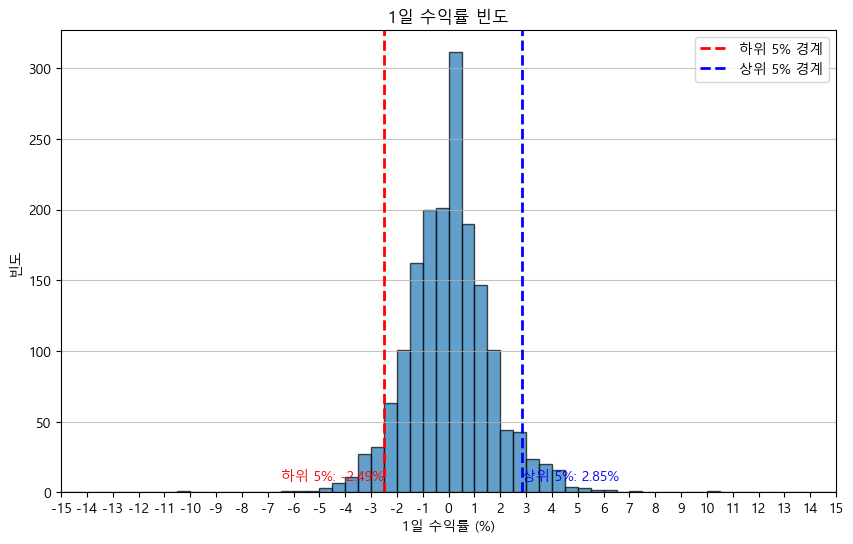

In [107]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 수익률 데이터 추출 및 백분율 변환
profit_returns = df_sec_price['1d_profit_rt'] * 100

# NaN 값 제거
profit_returns = profit_returns.dropna()

# 상위 10% 및 하위 10% 경계 계산
lower_bound = np.percentile(profit_returns, 5)
upper_bound = np.percentile(profit_returns, 95)

# 히스토그램 그리기
plt.figure(figsize=(10, 6)) 
plt.hist(profit_returns, bins=60, range=(-15, 15), edgecolor='black', alpha=0.7)
plt.title('1일 수익률 빈도')
plt.xlabel('1일 수익률 (%)')
plt.ylabel('빈도')
plt.xticks(range(-15, 16, 1))
plt.xlim(-15, 15)
plt.grid(axis='y', alpha=0.75)

# 경계 표시
plt.axvline(lower_bound, color='red', linestyle='dashed', linewidth=2, label='하위 5% 경계')
plt.axvline(upper_bound, color='blue', linestyle='dashed', linewidth=2, label='상위 5% 경계')

# 경계 값 표시
plt.text(lower_bound, plt.ylim()[1] * 0.02, f'하위 5%: {lower_bound:.2f}%', color='red', 
         verticalalignment='bottom', horizontalalignment='right')
plt.text(upper_bound, plt.ylim()[1] * 0.02, f'상위 5%: {upper_bound:.2f}%', color='blue', 
         verticalalignment='bottom', horizontalalignment='left')

# 범례 추가
plt.legend()

plt.show()

In [108]:
min(df_sentiment_analysis_merge['1d_profit_rt'])

-0.10301507537688442

1주 수익률

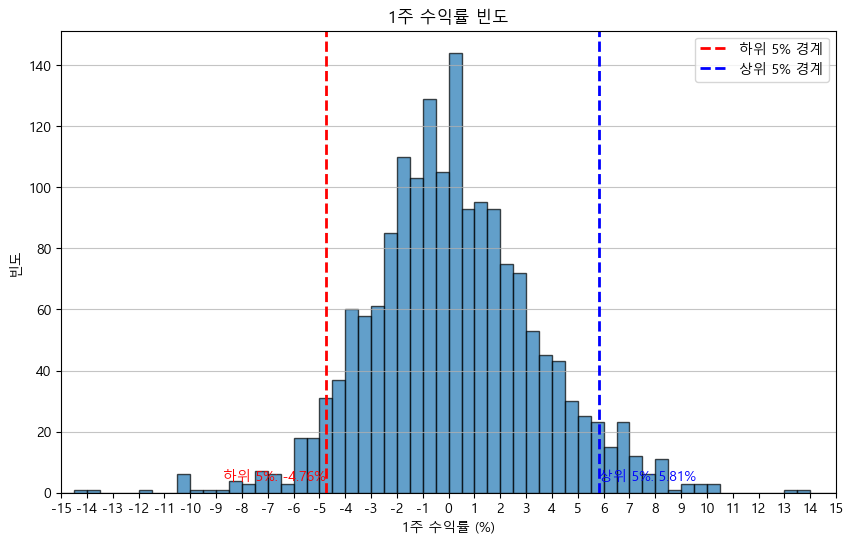

In [112]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 수익률 데이터 추출 및 백분율 변환
profit_returns = df_sec_price['1w_profit_rt'] * 100

# NaN 값 제거
profit_returns = profit_returns.dropna()

# 상위 10% 및 하위 10% 경계 계산
lower_bound = np.percentile(profit_returns, 5)
upper_bound = np.percentile(profit_returns, 95)

# 히스토그램 그리기
plt.figure(figsize=(10, 6)) 
plt.hist(profit_returns, bins=60, range=(-15, 15), edgecolor='black', alpha=0.7)
plt.title('1주 수익률 빈도')
plt.xlabel('1주 수익률 (%)')
plt.ylabel('빈도')
plt.xticks(range(-15, 16, 1))
plt.xlim(-15, 15)
plt.grid(axis='y', alpha=0.75)

# 경계 표시
plt.axvline(lower_bound, color='red', linestyle='dashed', linewidth=2, label='하위 5% 경계')
plt.axvline(upper_bound, color='blue', linestyle='dashed', linewidth=2, label='상위 5% 경계')

# 경계 값 표시
plt.text(lower_bound, plt.ylim()[1] * 0.02, f'하위 5%: {lower_bound:.2f}%', color='red', 
         verticalalignment='bottom', horizontalalignment='right')
plt.text(upper_bound, plt.ylim()[1] * 0.02, f'상위 5%: {upper_bound:.2f}%', color='blue', 
         verticalalignment='bottom', horizontalalignment='left')

# 범례 추가
plt.legend()

plt.show()

In [113]:
max(df_sentiment_analysis_merge['1w_profit_rt'])

0.13647058823529412

2주 수익률

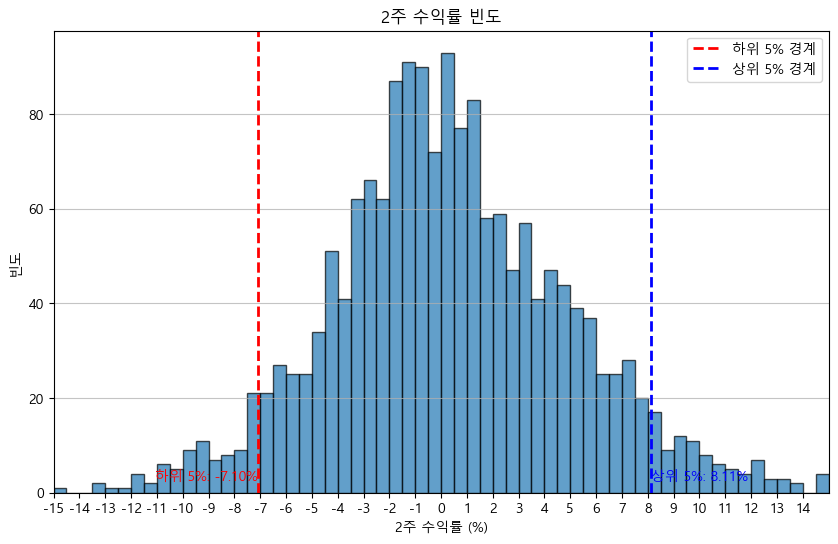

In [117]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 수익률 데이터 추출 및 백분율 변환
profit_returns = df_sec_price['2w_profit_rt'] * 100

# NaN 값 제거
profit_returns = profit_returns.dropna()

# 상위 10% 및 하위 10% 경계 계산
lower_bound = np.percentile(profit_returns, 5)
upper_bound = np.percentile(profit_returns, 95)

# 히스토그램 그리기
plt.figure(figsize=(10, 6)) 
plt.hist(profit_returns, bins=60, range=(-15, 15), edgecolor='black', alpha=0.7)
plt.title('2주 수익률 빈도')
plt.xlabel('2주 수익률 (%)')
plt.ylabel('빈도')
plt.xticks(range(-15, 15, 1))
plt.xlim(-15, 15)
plt.grid(axis='y', alpha=0.75)

# 경계 표시
plt.axvline(lower_bound, color='red', linestyle='dashed', linewidth=2, label='하위 5% 경계')
plt.axvline(upper_bound, color='blue', linestyle='dashed', linewidth=2, label='상위 5% 경계')

# 경계 값 표시
plt.text(lower_bound, plt.ylim()[1] * 0.02, f'하위 5%: {lower_bound:.2f}%', color='red', 
         verticalalignment='bottom', horizontalalignment='right')
plt.text(upper_bound, plt.ylim()[1] * 0.02, f'상위 5%: {upper_bound:.2f}%', color='blue', 
         verticalalignment='bottom', horizontalalignment='left')

# 범례 추가
plt.legend()

plt.show()

In [118]:
min(df_sentiment_analysis_merge['2w_profit_rt'])

-0.2398230088495575

1개월 수익률

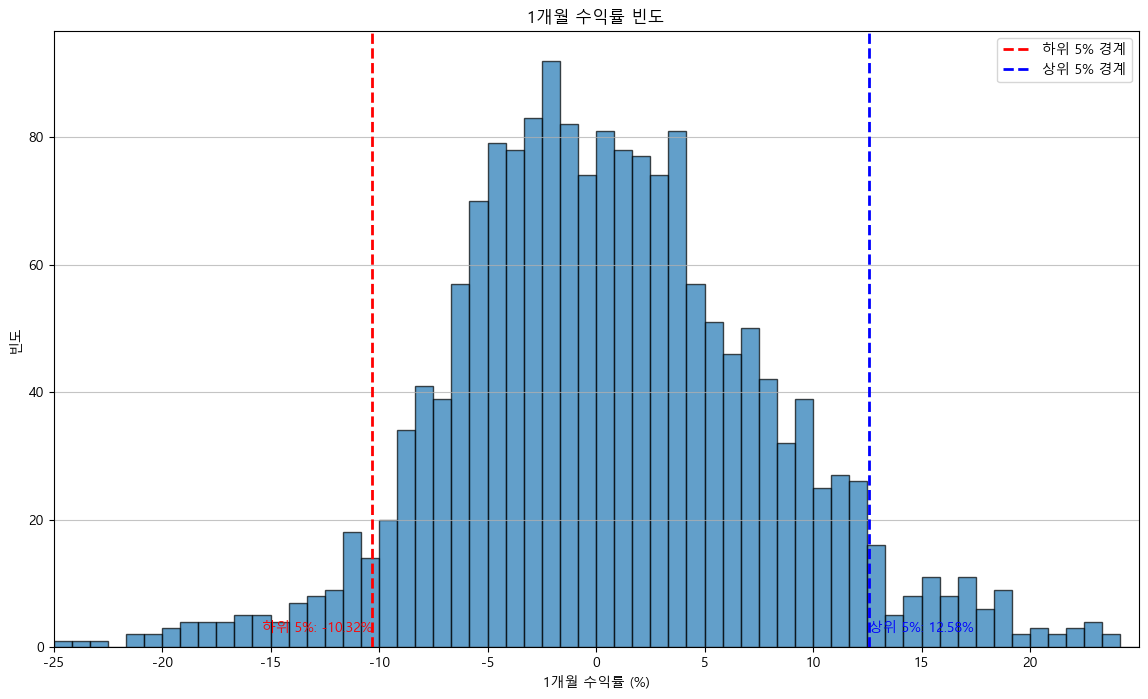

In [122]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 수익률 데이터 추출 및 백분율 변환
profit_returns = df_sec_price['1m_profit_rt'] * 100

# NaN 값 제거
profit_returns = profit_returns.dropna()

# 상위 10% 및 하위 10% 경계 계산
lower_bound = np.percentile(profit_returns, 5)
upper_bound = np.percentile(profit_returns, 95)

# 히스토그램 그리기
plt.figure(figsize=(14, 8))
plt.hist(profit_returns, bins=60, range=(-25, 25), edgecolor='black', alpha=0.7)
plt.title('1개월 수익률 빈도')
plt.xlabel('1개월 수익률 (%)')
plt.ylabel('빈도')
plt.xticks(range(-25, 25, 5))  # X축 눈금 조정
plt.xlim(-25, 25)
plt.grid(axis='y', alpha=0.75)

# 경계 표시
plt.axvline(lower_bound, color='red', linestyle='dashed', linewidth=2, label='하위 5% 경계')
plt.axvline(upper_bound, color='blue', linestyle='dashed', linewidth=2, label='상위 5% 경계')

# 경계 값 표시
plt.text(lower_bound, plt.ylim()[1] * 0.02, f'하위 5%: {lower_bound:.2f}%', color='red', 
         verticalalignment='bottom', horizontalalignment='right')
plt.text(upper_bound, plt.ylim()[1] * 0.02, f'상위 5%: {upper_bound:.2f}%', color='blue', 
         verticalalignment='bottom', horizontalalignment='left')

# 범례 추가
plt.legend()

plt.show()

In [124]:
max(df_sentiment_analysis_merge['1m_profit_rt'])

0.2691771269177127

주성님 것 감정분석

In [127]:
df_sec_return_label_merge # 수익률과 label

,Date,1d_profit_rt,1w_profit_rt,2w_profit_rt,1m_profit_rt,1d_label,1w_label,2w_label,1m_label
0,2017-09-01,0.015639,0.066030,0.094700,0.186794,1,1,1,1
1,2017-09-02,0.015639,0.066030,0.094700,0.186794,1,1,1,1
2,2017-09-03,0.015639,0.066030,0.094700,0.186794,1,1,1,1
3,2017-09-04,0.005133,0.065013,0.122327,0.171942,1,1,1,1
4,2017-09-05,0.023830,0.055319,0.108936,0.148936,1,1,1,1
...,...,...,...,...,...,...,...,...,...
2551,2024-08-26,0.007916,-0.018470,-0.109499,-0.188654,1,-1,-1,-1
2552,2024-08-27,-0.031414,-0.051047,-0.133508,-0.197644,-1,-1,-1,-1
2553,2024-08-28,0.004054,-0.054054,-0.122973,-0.181081,1,-1,-1,-1
2554,2024-08-29,0.001346,-0.071332,-0.107672,-0.179004,1,-1,-1,-1


In [129]:
import pandas as pd

# 파일 리스트
file_list = [
'./Text_Data/Samsung_bigkind_sentiment_merge.csv'
]
# 결과를 저장할 리스트
result_list = []

# 결과를 저장할 DataFrame 초기화
df_accuracy_all = pd.DataFrame()
df_corr_all = pd.DataFrame()

# 감정분석 결과 labeling
def label_sentiment(sentiment):
    if profit > 0:
        return 1
    elif profit < 0:
        return -1
    else:
        return 0
 
# 파일별 데이터 건수 확인
for file in file_list:
    df_sentiment_analysis = pd.read_csv(file)  # 엑셀 파일을 읽음
    print(file)
    # df_sentiment_analysis = df_sentiment_analysis.rename(columns={'date': 'Date'})
    # # df_sentiment_analysis에 컬럼 추가
    # # loc을 사용하여 값 할당
    df_sentiment_analysis.loc[:, 'KoBERT_label']    = df_sentiment_analysis['NEWS_kobert_sentiment'].apply(label_profit)
    df_sentiment_analysis.loc[:, 'KoFinBERT_label'] = df_sentiment_analysis['NEWS_kofinbert_sentiment'].apply(label_profit)
    df_sentiment_analysis.loc[:, 'ChatGPT_label']   = df_sentiment_analysis['NEWS_gpt_sentiment'].apply(label_profit)

    df_sentiment_analysis['Date'] = pd.to_datetime(df_sentiment_analysis['Date'])
    df_sec_return_label_merge['Date'] = pd.to_datetime(df_sec_return_label_merge['Date'])

    # 감정 분석 데이터와 수익률 데이터의 병합
    df_sentiment_analysis_merge = pd.merge(df_sentiment_analysis, df_sec_return_label_merge, on='Date', how='inner')

    # # KoBERT_label과 1d_label이 일치하면 True, 아니면 False로 설정
    df_sentiment_analysis_merge['1d_KoBERT_match']    = df_sentiment_analysis_merge['KoBERT_label']    == df_sentiment_analysis_merge['1d_label']
    df_sentiment_analysis_merge['1d_KoFinBERT_match'] = df_sentiment_analysis_merge['KoFinBERT_label'] == df_sentiment_analysis_merge['1d_label']
    df_sentiment_analysis_merge['1d_ChatGPT_match']   = df_sentiment_analysis_merge['ChatGPT_label']   == df_sentiment_analysis_merge['1d_label']
    df_sentiment_analysis_merge['1w_KoBERT_match']    = df_sentiment_analysis_merge['KoBERT_label']    == df_sentiment_analysis_merge['1w_label']
    df_sentiment_analysis_merge['1w_KoFinBERT_match'] = df_sentiment_analysis_merge['KoFinBERT_label'] == df_sentiment_analysis_merge['1w_label']
    df_sentiment_analysis_merge['1w_ChatGPT_match']   = df_sentiment_analysis_merge['ChatGPT_label']   == df_sentiment_analysis_merge['1w_label']
    df_sentiment_analysis_merge['2w_KoBERT_match']    = df_sentiment_analysis_merge['KoBERT_label']    == df_sentiment_analysis_merge['2w_label']
    df_sentiment_analysis_merge['2w_KoFinBERT_match'] = df_sentiment_analysis_merge['KoFinBERT_label'] == df_sentiment_analysis_merge['2w_label']
    df_sentiment_analysis_merge['2w_ChatGPT_match']   = df_sentiment_analysis_merge['ChatGPT_label']   == df_sentiment_analysis_merge['2w_label']
    df_sentiment_analysis_merge['1m_KoBERT_match']    = df_sentiment_analysis_merge['KoBERT_label']    == df_sentiment_analysis_merge['1m_label']
    df_sentiment_analysis_merge['1m_KoFinBERT_match'] = df_sentiment_analysis_merge['KoFinBERT_label'] == df_sentiment_analysis_merge['1m_label']
    df_sentiment_analysis_merge['1m_ChatGPT_match']   = df_sentiment_analysis_merge['ChatGPT_label']   == df_sentiment_analysis_merge['1m_label']
    # # 정확도 측정
    ld_1d_KoBERT_acc      = round(df_sentiment_analysis_merge['1d_KoBERT_match'].sum()/len(df_sentiment_analysis_merge)*100,2)
    ld_1d_KoFinBERT_acc   = round(df_sentiment_analysis_merge['1d_KoFinBERT_match'].sum()/len(df_sentiment_analysis_merge)*100,2)
    ld_1d_ChatGPT_acc     = round(df_sentiment_analysis_merge['1d_ChatGPT_match'].sum()/len(df_sentiment_analysis_merge)*100,2)
    ld_1w_KoBERT_acc      = round(df_sentiment_analysis_merge['1w_KoBERT_match'].sum()/len(df_sentiment_analysis_merge)*100,2)
    ld_1w_KoFinBERT_acc   = round(df_sentiment_analysis_merge['1w_KoFinBERT_match'].sum()/len(df_sentiment_analysis_merge)*100,2)
    ld_1w_ChatGPT_acc     = round(df_sentiment_analysis_merge['1w_ChatGPT_match'].sum()/len(df_sentiment_analysis_merge)*100,2)
    ld_2w_KoBERT_acc      = round(df_sentiment_analysis_merge['2w_KoBERT_match'].sum()/len(df_sentiment_analysis_merge)*100,2)
    ld_2w_KoFinBERT_acc   = round(df_sentiment_analysis_merge['2w_KoFinBERT_match'].sum()/len(df_sentiment_analysis_merge)*100,2)
    ld_2w_ChatGPT_acc     = round(df_sentiment_analysis_merge['2w_ChatGPT_match'].sum()/len(df_sentiment_analysis_merge)*100,2)
    ld_1m_KoBERT_acc      = round(df_sentiment_analysis_merge['1m_KoBERT_match'].sum()/len(df_sentiment_analysis_merge)*100,2)
    ld_1m_KoFinBERT_acc   = round(df_sentiment_analysis_merge['1m_KoFinBERT_match'].sum()/len(df_sentiment_analysis_merge)*100,2)
    ld_1m_ChatGPT_acc     = round(df_sentiment_analysis_merge['1m_ChatGPT_match'].sum()/len(df_sentiment_analysis_merge)*100,2)
    # df_accuracy DataFrame 생성 및 값 추가
    df_accuracy2 = pd.DataFrame({
        '1d_KoBERT_acc'    : [ld_1d_KoBERT_acc   ],
        '1d_KoFinBERT_acc' : [ld_1d_KoFinBERT_acc],
        '1d_ChatGPT_acc'   : [ld_1d_ChatGPT_acc  ],
        '1w_KoBERT_acc'    : [ld_1w_KoBERT_acc   ],
        '1w_KoFinBERT_acc' : [ld_1w_KoFinBERT_acc],
        '1w_ChatGPT_acc'   : [ld_1w_ChatGPT_acc  ],
        '2w_KoBERT_acc'    : [ld_2w_KoBERT_acc   ],
        '2w_KoFinBERT_acc' : [ld_2w_KoFinBERT_acc],
        '2w_ChatGPT_acc'   : [ld_2w_ChatGPT_acc  ],
        '1m_KoBERT_acc'    : [ld_1m_KoBERT_acc   ],
        '1m_KoFinBERT_acc' : [ld_1m_KoFinBERT_acc],
        '1m_ChatGPT_acc'   : [ld_1m_ChatGPT_acc  ]
    })

    # 상관관계 측정
    ld_1d_KoBERT_corr    = df_sentiment_analysis_merge['KoBERT_Sentiment'].corr(df_sentiment_analysis_merge['1d_profit_rt'])
    ld_1d_KoFinBERT_corr = df_sentiment_analysis_merge['KoFinBERT_Sentiment'].corr(df_sentiment_analysis_merge['1d_profit_rt'])
    ld_1d_ChatGPT_corr   = df_sentiment_analysis_merge['ChatGPT_Sentiment'].corr(df_sentiment_analysis_merge['1d_profit_rt'])
    ld_1w_KoBERT_corr    = df_sentiment_analysis_merge['KoBERT_Sentiment'].corr(df_sentiment_analysis_merge['1w_profit_rt'])
    ld_1w_KoFinBERT_corr = df_sentiment_analysis_merge['KoFinBERT_Sentiment'].corr(df_sentiment_analysis_merge['1w_profit_rt'])
    ld_1w_ChatGPT_corr   = df_sentiment_analysis_merge['ChatGPT_Sentiment'].corr(df_sentiment_analysis_merge['1w_profit_rt'])
    ld_2w_KoBERT_corr    = df_sentiment_analysis_merge['KoBERT_Sentiment'].corr(df_sentiment_analysis_merge['2w_profit_rt'])
    ld_2w_KoFinBERT_corr = df_sentiment_analysis_merge['KoFinBERT_Sentiment'].corr(df_sentiment_analysis_merge['2w_profit_rt'])
    ld_2w_ChatGPT_corr   = df_sentiment_analysis_merge['ChatGPT_Sentiment'].corr(df_sentiment_analysis_merge['2w_profit_rt'])
    ld_1m_KoBERT_corr    = df_sentiment_analysis_merge['KoBERT_Sentiment'].corr(df_sentiment_analysis_merge['1m_profit_rt'])
    ld_1m_KoFinBERT_corr = df_sentiment_analysis_merge['KoFinBERT_Sentiment'].corr(df_sentiment_analysis_merge['1m_profit_rt'])
    ld_1m_ChatGPT_corr   = df_sentiment_analysis_merge['ChatGPT_Sentiment'].corr(df_sentiment_analysis_merge['1m_profit_rt'])
    
    # 상관관계 데이터생성
    df_corr = pd.DataFrame({
        '1d_KoBERT_corr'    : [ld_1d_KoBERT_corr   ],
        '1d_KoFinBERT_corr' : [ld_1d_KoFinBERT_corr],
        '1d_ChatGPT_corr'   : [ld_1d_ChatGPT_corr  ],
        '1w_KoBERT_corr'    : [ld_1w_KoBERT_corr   ],
        '1w_KoFinBERT_corr' : [ld_1w_KoFinBERT_corr],
        '1w_ChatGPT_corr'   : [ld_1w_ChatGPT_corr  ],
        '2w_KoBERT_corr'    : [ld_2w_KoBERT_corr   ],
        '2w_KoFinBERT_corr' : [ld_2w_KoFinBERT_corr],
        '2w_ChatGPT_corr'   : [ld_2w_ChatGPT_corr  ],
        '1m_KoBERT_corr'    : [ld_1m_KoBERT_corr   ],
        '1m_KoFinBERT_corr' : [ld_1m_KoFinBERT_corr],
        '1m_ChatGPT_corr'   : [ld_1m_ChatGPT_corr  ]
    })

    # df_accuracy와 df_corr을 각각 누적 저장
    df_accuracy_all = pd.concat([df_accuracy_all, df_accuracy], ignore_index=True)
    df_corr_all = pd.concat([df_corr_all, df_corr], ignore_index=True)

./Text_Data/Samsung_bigkind_sentiment_merge.csv


KeyError: 'KoBERT_Sentiment'

감정분석 정확도

In [132]:
df_accuracy2

,1d_KoBERT_acc,1d_KoFinBERT_acc,1d_ChatGPT_acc,1w_KoBERT_acc,1w_KoFinBERT_acc,1w_ChatGPT_acc,2w_KoBERT_acc,2w_KoFinBERT_acc,2w_ChatGPT_acc,1m_KoBERT_acc,1m_KoFinBERT_acc,1m_ChatGPT_acc
0,38.02,29.31,39.23,40.33,29.7,38.61,39.7,28.76,38.61,38.53,30.13,40.91


In [134]:
웅진님 것 감정분석

SyntaxError: invalid syntax (2592585598.py, line 1)

In [136]:
import pandas as pd

# 파일 리스트
file_list = [
'./Text_Data/Community_Sentiment.csv'
]
# 결과를 저장할 리스트
result_list = []

# 결과를 저장할 DataFrame 초기화
df_accuracy_all = pd.DataFrame()
df_corr_all = pd.DataFrame()

# 감정분석 결과 labeling
def label_sentiment(sentiment):
    if profit > 0:
        return 1
    elif profit < 0:
        return -1
    else:
        return 0
 
# 파일별 데이터 건수 확인
for file in file_list:
    df_sentiment_analysis = pd.read_csv(file)  # 엑셀 파일을 읽음
    print(file)
    # df_sentiment_analysis = df_sentiment_analysis.rename(columns={'date': 'Date'})
    # # df_sentiment_analysis에 컬럼 추가
    # # loc을 사용하여 값 할당
    df_sentiment_analysis.loc[:, 'KoBERT_label']    = df_sentiment_analysis['Community_KoBert_Sentiment'].apply(label_profit)
    df_sentiment_analysis.loc[:, 'KoFinBERT_label'] = df_sentiment_analysis['Community_KoFinBert_Sentiment'].apply(label_profit)
    df_sentiment_analysis.loc[:, 'ChatGPT_label']   = df_sentiment_analysis['Community_GPT_Sentiment'].apply(label_profit)

    df_sentiment_analysis['Date'] = pd.to_datetime(df_sentiment_analysis['Date'])
    df_sec_return_label_merge['Date'] = pd.to_datetime(df_sec_return_label_merge['Date'])

    # 감정 분석 데이터와 수익률 데이터의 병합
    df_sentiment_analysis_merge = pd.merge(df_sentiment_analysis, df_sec_return_label_merge, on='Date', how='inner')

    # # KoBERT_label과 1d_label이 일치하면 True, 아니면 False로 설정
    df_sentiment_analysis_merge['1d_KoBERT_match']    = df_sentiment_analysis_merge['KoBERT_label']    == df_sentiment_analysis_merge['1d_label']
    df_sentiment_analysis_merge['1d_KoFinBERT_match'] = df_sentiment_analysis_merge['KoFinBERT_label'] == df_sentiment_analysis_merge['1d_label']
    df_sentiment_analysis_merge['1d_ChatGPT_match']   = df_sentiment_analysis_merge['ChatGPT_label']   == df_sentiment_analysis_merge['1d_label']
    df_sentiment_analysis_merge['1w_KoBERT_match']    = df_sentiment_analysis_merge['KoBERT_label']    == df_sentiment_analysis_merge['1w_label']
    df_sentiment_analysis_merge['1w_KoFinBERT_match'] = df_sentiment_analysis_merge['KoFinBERT_label'] == df_sentiment_analysis_merge['1w_label']
    df_sentiment_analysis_merge['1w_ChatGPT_match']   = df_sentiment_analysis_merge['ChatGPT_label']   == df_sentiment_analysis_merge['1w_label']
    df_sentiment_analysis_merge['2w_KoBERT_match']    = df_sentiment_analysis_merge['KoBERT_label']    == df_sentiment_analysis_merge['2w_label']
    df_sentiment_analysis_merge['2w_KoFinBERT_match'] = df_sentiment_analysis_merge['KoFinBERT_label'] == df_sentiment_analysis_merge['2w_label']
    df_sentiment_analysis_merge['2w_ChatGPT_match']   = df_sentiment_analysis_merge['ChatGPT_label']   == df_sentiment_analysis_merge['2w_label']
    df_sentiment_analysis_merge['1m_KoBERT_match']    = df_sentiment_analysis_merge['KoBERT_label']    == df_sentiment_analysis_merge['1m_label']
    df_sentiment_analysis_merge['1m_KoFinBERT_match'] = df_sentiment_analysis_merge['KoFinBERT_label'] == df_sentiment_analysis_merge['1m_label']
    df_sentiment_analysis_merge['1m_ChatGPT_match']   = df_sentiment_analysis_merge['ChatGPT_label']   == df_sentiment_analysis_merge['1m_label']
    # # 정확도 측정
    ld_1d_KoBERT_acc      = round(df_sentiment_analysis_merge['1d_KoBERT_match'].sum()/len(df_sentiment_analysis_merge)*100,2)
    ld_1d_KoFinBERT_acc   = round(df_sentiment_analysis_merge['1d_KoFinBERT_match'].sum()/len(df_sentiment_analysis_merge)*100,2)
    ld_1d_ChatGPT_acc     = round(df_sentiment_analysis_merge['1d_ChatGPT_match'].sum()/len(df_sentiment_analysis_merge)*100,2)
    ld_1w_KoBERT_acc      = round(df_sentiment_analysis_merge['1w_KoBERT_match'].sum()/len(df_sentiment_analysis_merge)*100,2)
    ld_1w_KoFinBERT_acc   = round(df_sentiment_analysis_merge['1w_KoFinBERT_match'].sum()/len(df_sentiment_analysis_merge)*100,2)
    ld_1w_ChatGPT_acc     = round(df_sentiment_analysis_merge['1w_ChatGPT_match'].sum()/len(df_sentiment_analysis_merge)*100,2)
    ld_2w_KoBERT_acc      = round(df_sentiment_analysis_merge['2w_KoBERT_match'].sum()/len(df_sentiment_analysis_merge)*100,2)
    ld_2w_KoFinBERT_acc   = round(df_sentiment_analysis_merge['2w_KoFinBERT_match'].sum()/len(df_sentiment_analysis_merge)*100,2)
    ld_2w_ChatGPT_acc     = round(df_sentiment_analysis_merge['2w_ChatGPT_match'].sum()/len(df_sentiment_analysis_merge)*100,2)
    ld_1m_KoBERT_acc      = round(df_sentiment_analysis_merge['1m_KoBERT_match'].sum()/len(df_sentiment_analysis_merge)*100,2)
    ld_1m_KoFinBERT_acc   = round(df_sentiment_analysis_merge['1m_KoFinBERT_match'].sum()/len(df_sentiment_analysis_merge)*100,2)
    ld_1m_ChatGPT_acc     = round(df_sentiment_analysis_merge['1m_ChatGPT_match'].sum()/len(df_sentiment_analysis_merge)*100,2)
    # df_accuracy DataFrame 생성 및 값 추가
    df_accuracy3 = pd.DataFrame({
        '1d_KoBERT_acc'    : [ld_1d_KoBERT_acc   ],
        '1d_KoFinBERT_acc' : [ld_1d_KoFinBERT_acc],
        '1d_ChatGPT_acc'   : [ld_1d_ChatGPT_acc  ],
        '1w_KoBERT_acc'    : [ld_1w_KoBERT_acc   ],
        '1w_KoFinBERT_acc' : [ld_1w_KoFinBERT_acc],
        '1w_ChatGPT_acc'   : [ld_1w_ChatGPT_acc  ],
        '2w_KoBERT_acc'    : [ld_2w_KoBERT_acc   ],
        '2w_KoFinBERT_acc' : [ld_2w_KoFinBERT_acc],
        '2w_ChatGPT_acc'   : [ld_2w_ChatGPT_acc  ],
        '1m_KoBERT_acc'    : [ld_1m_KoBERT_acc   ],
        '1m_KoFinBERT_acc' : [ld_1m_KoFinBERT_acc],
        '1m_ChatGPT_acc'   : [ld_1m_ChatGPT_acc  ]
    })

    # 상관관계 측정
    ld_1d_KoBERT_corr    = df_sentiment_analysis_merge['KoBERT_Sentiment'].corr(df_sentiment_analysis_merge['1d_profit_rt'])
    ld_1d_KoFinBERT_corr = df_sentiment_analysis_merge['KoFinBERT_Sentiment'].corr(df_sentiment_analysis_merge['1d_profit_rt'])
    ld_1d_ChatGPT_corr   = df_sentiment_analysis_merge['ChatGPT_Sentiment'].corr(df_sentiment_analysis_merge['1d_profit_rt'])
    ld_1w_KoBERT_corr    = df_sentiment_analysis_merge['KoBERT_Sentiment'].corr(df_sentiment_analysis_merge['1w_profit_rt'])
    ld_1w_KoFinBERT_corr = df_sentiment_analysis_merge['KoFinBERT_Sentiment'].corr(df_sentiment_analysis_merge['1w_profit_rt'])
    ld_1w_ChatGPT_corr   = df_sentiment_analysis_merge['ChatGPT_Sentiment'].corr(df_sentiment_analysis_merge['1w_profit_rt'])
    ld_2w_KoBERT_corr    = df_sentiment_analysis_merge['KoBERT_Sentiment'].corr(df_sentiment_analysis_merge['2w_profit_rt'])
    ld_2w_KoFinBERT_corr = df_sentiment_analysis_merge['KoFinBERT_Sentiment'].corr(df_sentiment_analysis_merge['2w_profit_rt'])
    ld_2w_ChatGPT_corr   = df_sentiment_analysis_merge['ChatGPT_Sentiment'].corr(df_sentiment_analysis_merge['2w_profit_rt'])
    ld_1m_KoBERT_corr    = df_sentiment_analysis_merge['KoBERT_Sentiment'].corr(df_sentiment_analysis_merge['1m_profit_rt'])
    ld_1m_KoFinBERT_corr = df_sentiment_analysis_merge['KoFinBERT_Sentiment'].corr(df_sentiment_analysis_merge['1m_profit_rt'])
    ld_1m_ChatGPT_corr   = df_sentiment_analysis_merge['ChatGPT_Sentiment'].corr(df_sentiment_analysis_merge['1m_profit_rt'])
    
    # 상관관계 데이터생성
    df_corr = pd.DataFrame({
        '1d_KoBERT_corr'    : [ld_1d_KoBERT_corr   ],
        '1d_KoFinBERT_corr' : [ld_1d_KoFinBERT_corr],
        '1d_ChatGPT_corr'   : [ld_1d_ChatGPT_corr  ],
        '1w_KoBERT_corr'    : [ld_1w_KoBERT_corr   ],
        '1w_KoFinBERT_corr' : [ld_1w_KoFinBERT_corr],
        '1w_ChatGPT_corr'   : [ld_1w_ChatGPT_corr  ],
        '2w_KoBERT_corr'    : [ld_2w_KoBERT_corr   ],
        '2w_KoFinBERT_corr' : [ld_2w_KoFinBERT_corr],
        '2w_ChatGPT_corr'   : [ld_2w_ChatGPT_corr  ],
        '1m_KoBERT_corr'    : [ld_1m_KoBERT_corr   ],
        '1m_KoFinBERT_corr' : [ld_1m_KoFinBERT_corr],
        '1m_ChatGPT_corr'   : [ld_1m_ChatGPT_corr  ]
    })

    # df_accuracy와 df_corr을 각각 누적 저장
    df_accuracy_all = pd.concat([df_accuracy_all, df_accuracy], ignore_index=True)
    df_corr_all = pd.concat([df_corr_all, df_corr], ignore_index=True)

./Text_Data/Community_Sentiment.csv


KeyError: 'KoBERT_Sentiment'

In [138]:
df_accuracy2

,1d_KoBERT_acc,1d_KoFinBERT_acc,1d_ChatGPT_acc,1w_KoBERT_acc,1w_KoFinBERT_acc,1w_ChatGPT_acc,2w_KoBERT_acc,2w_KoFinBERT_acc,2w_ChatGPT_acc,1m_KoBERT_acc,1m_KoFinBERT_acc,1m_ChatGPT_acc
0,38.02,29.31,39.23,40.33,29.7,38.61,39.7,28.76,38.61,38.53,30.13,40.91
